# Передискретизация РАСТРА #

### Передискретизация растра (или ресемплирование растра) — это процесс изменения размера растрового изображения, который включает в себя изменение количества пикселей или точек изображения в горизонтальном и вертикальном направлениях. Этот процесс используется для адаптации изображений к различным разрешениям экранов или печатных устройств, а также для оптимизации изображений под конкретные задачи обработки или анализа. ###

Квантование и дискретизация сигналов


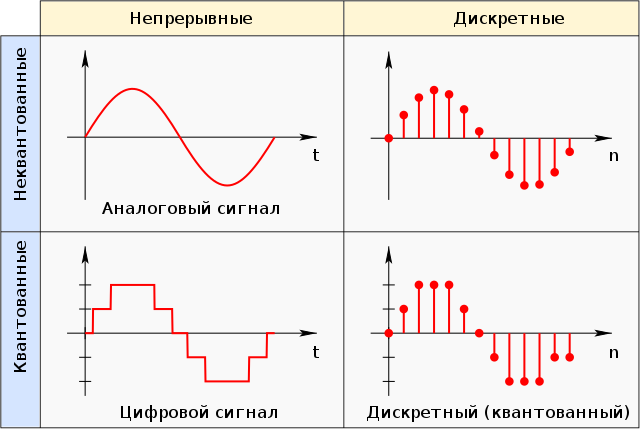

In [4]:

from IPython.display import Image
print('Квантование и дискретизация сигналов')
Image("imgs/kvant.png", width=740, height=540) 

## Однопроходная передискретизация

- Размер выходного изображения задаётся рациональным числом:
$$ 
( \frac{M}{N} )
$$
где M и N — это числители и знаменатели соответственно
- Для каждого пикселя выходного изображения цвет рассчитывается на основе исходного изображения по формуле:

$$
I(x, y) = I\left(\left\lfloor \frac{N}{M} \times x \right\rfloor, \left\lfloor \frac{N}{M} \times y \right\rfloor\right)
$$


где \( x \) и \( y \) — координаты пикселя в выходном изображении, а \( \lfloor \cdot \rfloor \) обозначает операцию округления вниз до ближайшего целого числа.

- Диапазоны значений \( x \) и \( y \) задаются как:

$$
x \in \left[0..\frac{W \cdot M}{N} - 1\right]
$$


$$
y \in \left[0..\frac{H \cdot M}{N} - 1\right]
$$


где \( W \) и \( H \) — ширина и высота исходного изображения соответственно.


In [6]:
import numpy as np
from PIL import Image as pim

# Загрузка исходного изображения и преобразование его в массив NumPy
input_image = pim.open('imgs/muar.png')
input_array = np.array(input_image)

# Параметры M и N для рационального числа M/N, определяющего размер выходного изображения
# M, N = list(map(int, input().split()))
M, N = 10, 20 # 0.5

# Размеры исходного изображения
H, W = input_array.shape[:2]

# Размеры выходного изображения
new_H = H * M // N
new_W = W * M // N

# Создание массива для выходного изображения
output_array = np.zeros((new_H, new_W, input_array.shape[2]), dtype=input_array.dtype)

# Алгоритм однопроходной передискретизации
for y in range(new_H):
    for x in range(new_W):
        # Вычисление координат в исходном изображении
        orig_y = N * y // M
        orig_x = N * x // M
        # Копирование значения пикселя
        output_array[y, x] = input_array[orig_y, orig_x]

# Преобразование выходного массива обратно в изображение
output_image = pim.fromarray(output_array)

# # Сохранение или отображение результата
output_image.save('resampled_image.png')
output_image.show()

## Билинейная Интерполяция или как можно убежать от муаровой тряпки

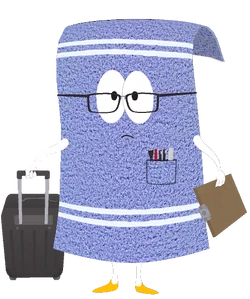

In [8]:

Image("imgs/towelie.png", width=250, height=299)

Билинейная интерполяция — это метод интерполяции, который использует четыре ближайших пикселя изображения для вычисления значения нового пикселя. Этот метод применяется для плавного изменения размера изображений и обеспечивает более качественный результат, чем простое копирование пикселей (метод ближайшего соседа).

Для пикселя с координатами $(x, y)$ в выходном изображении билинейная интерполяция определяется следующим образом:

1. Определяются координаты $(x_1, y_1)$, $(x_1, y_2)$, $(x_2, y_1)$, и $(x_2, y_2)$ четырех ближайших пикселей в исходном изображении, которые окружают точку $(x', y')$, где $x' = x \cdot \frac{N}{M}$ и $y' = y \cdot \frac{N}{M}$.

2. Вычисляются расстояния $dx = x' - x_1$ и $dy = y' - y_1$, которые представляют собой горизонтальное и вертикальное смещение относительно ближайшего левого верхнего пикселя.

3. Значение нового пикселя $(x, y)$ вычисляется как взвешенная сумма значений четырех окружающих пикселей:

$$
I(x, y) = I(x_1, y_1) \cdot (1 - dx) \cdot (1 - dy) + I(x_1, y_2) \cdot (1 - dx) \cdot dy + I(x_2, y_1) \cdot dx \cdot (1 - dy) + I(x_2, y_2) \cdot dx \cdot dy
$$


где $I(x_1, y_1)$, $I(x_1, y_2)$, $I(x_2, y_1)$, и $I(x_2, y_2)$ — значения пикселей исходного изображения, а $dx$ и $dy$ — веса, основанные на расстоянии до каждого из четырех пикселей.

Билинейная интерполяция обеспечивает плавный переход между пикселями, что делает ее подходящей для масштабирования изображений, когда необходимо сохранить визуальное качество без резких переходов и артефактов.


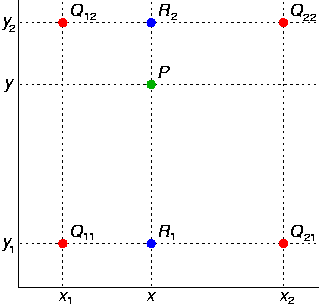

In [9]:

Image("imgs/Bilinear_interpolation.png", width=250, height=299)

In [10]:
def bilinear_interpolate(image, new_width, new_height):
    src_height, src_width = image.shape[:2]
    # Создаем сетку координат для исходного изображения
    src_x = np.linspace(0, src_width - 1, num=new_width)
    src_y = np.linspace(0, src_height - 1, num=new_height)
    src_x, src_y = np.meshgrid(src_x, src_y)
    
    # Вычисляем координаты ближайших пикселей
    x0 = np.floor(src_x).astype(int)
    x1 = np.clip(x0 + 1, 0, src_width - 1)
    y0 = np.floor(src_y).astype(int)
    y1 = np.clip(y0 + 1, 0, src_height - 1)
    
    # Вычисляем веса для интерполяции
    wx = (src_x - x0)[..., np.newaxis]
    wy = (src_y - y0)[..., np.newaxis]
    
    # Интерполируем значения
    output = (image[y0, x0] * (1 - wx) * (1 - wy) +
              image[y0, x1] * wx * (1 - wy) +
              image[y1, x0] * (1 - wx) * wy +
              image[y1, x1] * wx * wy)
    
    return output
input_image = pim.open('imgs/muar.png')
input_array = np.array(input_image)


M, N = 10, 20

H, W = input_array.shape[:2]


new_H = H * M // N - 1
new_W = W * M // N - 1

# Применяем билинейную интерполяцию
output_array = bilinear_interpolate(input_array, new_W, new_H)

output_image = pim.fromarray(output_array.astype('uint8'))

output_image.save('resampled_image_filtered.jpg')
output_image.show()

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
x = np.array([0, 2, 0, 2])
y = np.array([0, 0, 4, 4])
Z = np.array([[100, 40], [90, 180]])
z = Z.ravel()
pd.DataFrame(data = [x, y, z], index=["x", "y", "z"])

0   1   2    3
x    0   2   0    2
y    0   0   4    4
z  100  40  90  180

In [9]:
# промежуточная точка 
xnew, ynew = 1, 3

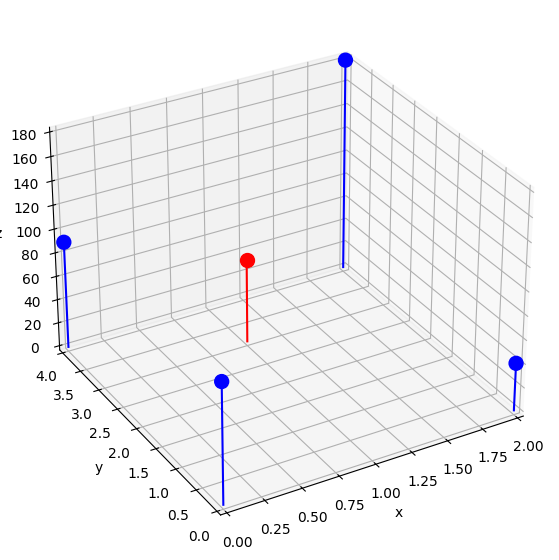

In [10]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))
ax.set_zlim(0, max(z))
ax.scatter3D(x, y, z, s=100, c="blue", alpha=1)
ax.scatter3D(xnew, ynew, 70, s=100, c="red", alpha=1)
for i in range(len(z)):
    ax.plot3D([x[i], x[i]], [y[i], y[i]], [0, z[i]], c='blue', alpha=1)
ax.plot3D([xnew, xnew], [ynew, ynew], [0, 70], c='red', alpha=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.azim = -120
ax.elev = 30

plt.show()

### Уравнение прямой заданной 2 точками: 
$$
\frac{x - x_1}{x_2 - x_1} = \frac{z - z_1}{z_2 - z_1}
$$


In [11]:
def linterp(xnew, x1, x2, z1, z2):
    """Линейная интерполяция"""
    return (xnew - x1) * (z2 - z1) / (x2 - x1) + z1 

In [12]:
# Интерполируем по оси x
z1 = linterp(xnew, x[0], x[1], z[0], z[1])
z2 = linterp(xnew, x[2], x[3], z[2], z[3])
print(z1, z2)

70.0 135.0


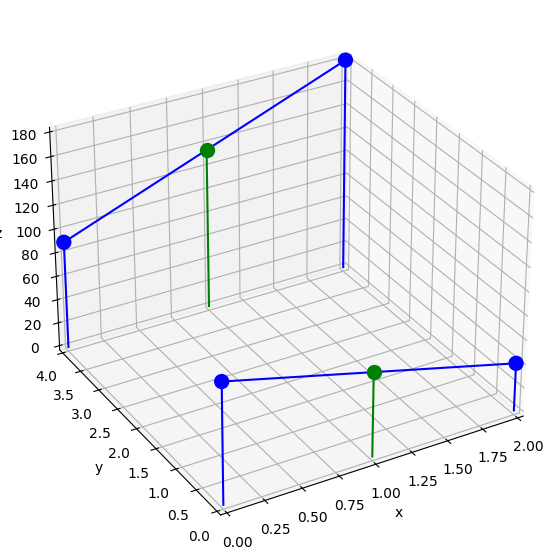

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))
ax.set_zlim(0, max(z))
ax.scatter3D(x, y, z, s=100, c='blue', alpha=1)

# Предполагается, что x1, y1, z1 и x2, y2, z2 - это координаты двух точек, между которыми происходит интерполяция
ax.plot3D((x[0], x[1]), (y[0], y[0]), (z[0], z[1]), c='blue', alpha=1)
ax.plot3D((x[2], x[3]), (y[2], y[2]), (z[2], z[3]), c='blue', alpha=1)
for i in range(len(z)):
    ax.plot3D((x[i], x[i]), (y[i], y[i]), (0, z[i]), c='blue', alpha=1)

# Предполагается, что xnew, ynew, znew - это координаты новой точки, полученной в результате интерполяции
ax.plot3D((xnew, xnew), (y[0], y[0]), (0, z1), c='green', alpha=1)
ax.plot3D((xnew, xnew), (y[2], y[2]), (0, z2), c='green', alpha=1)
ax.scatter3D(xnew, y[0], z1, s=100, c='green', alpha=1)
ax.scatter3D(xnew, y[2], z2, s=100, c='green', alpha=1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.azim = -120
ax.elev = 30
plt.show()

In [14]:
# Интерполируем по оси y
znew = linterp(ynew, y[0], y[2], z1, z2)
znew

118.75

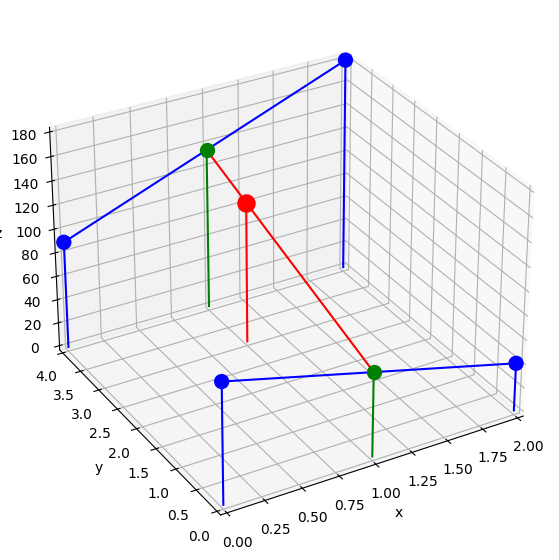

In [15]:


# Код для создания 3D графика
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))
ax.set_zlim(0, max(z))
ax.scatter3D(x, y, z, s=100, c='blue', alpha=1)


# Предполагается, что x1, y1, z1 и x2, y2, z2 - это координаты двух точек, между которыми происходит интерполяция
ax.plot3D((x[0], x[1]), (y[0], y[0]), (z[0], z[1]), c='blue', alpha=1)
ax.plot3D((x[2], x[3]), (y[2], y[2]), (z[2], z[3]), c='blue', alpha=1)
for i in range(len(z)):
    ax.plot3D((x[i], x[i]), (y[i], y[i]), (0, z[i]), c='blue', alpha=1)

# Предполагается, что xnew, ynew, znew - это координаты новой точки, полученной в результате интерполяции
ax.plot3D([xnew, xnew], [ynew, ynew], [0, znew], c='red', alpha=1)

ax.plot3D((xnew, xnew), (y[0], y[0]), (0, z1), c='green', alpha=1)
ax.plot3D((xnew, xnew), (y[2], y[2]), (0, z2), c='green', alpha=1)

ax.scatter3D(xnew, y[0], z1, s=100, c='green', alpha=1)
ax.scatter3D(xnew, y[2], z2, s=100, c='green', alpha=1)

ax.plot3D((xnew, xnew), (y[0], y[2]), (z1, z2), c='red', alpha=1)
ax.scatter3D(xnew, ynew, znew, s=150, c='red', alpha=1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.azim = -120
ax.elev = 30
plt.show()

In [16]:
def bilinterp(xnew, ynew, x, y, z):
    """Билинейная интерполяция"""
    z1 = linterp(xnew, x[0], x[1], z[0], z[1])
    z2 = linterp(xnew, x[2], x[3], z[2], z[3])
    znew = linterp(ynew, y[0], y[2], z1, z2)
    return znew

In [17]:
print('x =', x)
print('y =', y)
print('z =', z)
print('xnew =', xnew)
print('ynew =', ynew)
print('znew =', bilinterp(xnew, ynew, x, y, z))

x = [0 2 0 2]
y = [0 0 4 4]
z = [100  40  90 180]
xnew = 1
ynew = 3
znew = 118.75


In [18]:
from scipy.interpolate import RectBivariateSpline
# from PIL import Image as pim

In [19]:
# Исходное изображение
img = pim.open("imgs/kotik.png")
img = img.convert('L')
print(img.size)
# img1.show()

(1000, 666)


In [20]:
# обрезка фрагмента исходного изображения
img1 = img.crop((400, 400, 700, 700))
img1.show()

In [21]:
zoom = 3  # увеличение по каждой стороне

In [22]:
img2 = pim.new('L', (img1.width * zoom, img1.height * zoom), 'black')  # создаем новое изображение
np_img1 = np.asarray(img1, dtype=int)  # создаем массивы NumPy
np_img2 = np.asarray(img2, dtype=int)
np_img2[::zoom, ::zoom] = np_img1  # заполняем новое изображением имеющимися пикселями
pim.fromarray((np_img2.astype('uint8'))).show()

In [23]:
# Интерполяция отсутствующих пикселей или то как вам делать нелья (все ручками пишем)
interp = RectBivariateSpline(np.arange(0, np_img2.shape[0], zoom), np.arange(0, np_img2.shape[1], zoom), np_img2[::zoom, ::zoom], kx=1, ky=1)

np_img2 = interp(np.arange(0, np_img2.shape[0]), np.arange(0, np_img2.shape[1]))
np_img2 = np_img2.astype('uint8')
img2 = pim.fromarray(np_img2)
img1.show()
print()
img2.show()